#### Documentation:

Why this project:
- **Recommendations**: Predict what the customer wants to buy, and recommend what else they can buy
	- We can understand more about the customer using their behaviour, frequency, and preferences.
	- For example, if a customer buys a phone, we can recommend a phone cover, screen guard, etc.
- **Advertisements**: Sponsor the recommended products which customers are likely to buy, along with a discount
- Identify products that are frequently bought together
- **Abandoned carts**: Find list of searches or carts or user opening the project page, that are not converted to sales
	- If a customer searches for a product, but does not buy it, we can predict the reason, like the price is cheaper in another website.
- **Empty results**: Find the list of searches that returned no results, and find most searched products that are not in our inventory.
	- With this data, we can stock-up those products
- **Demand of the new products**: Find whether newly introduced products have more demand compared to products that have a long history of sales
- Identify users who don't want to order, so we can send them coupons
- **Sales forecasting**: Predict the time period of the year with highest sales (for example, Winter holidays)
- **Price Optimization**: Determine the optimal price point for a product that maximizes profit.
- **Identifying Trends**: Identify current market trends and customer preferences. (for example, what are being sold more in summer than rest of the year)

### Importing packages

In [1]:
# %pip install pandas numpy scikit-learn matplotlib seaborn

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import itertools


### Defining constant values

In [3]:
n_products = 10_000  # 100_000
# number of active customers
n_customers = 100  # 1000
n_activities = n_customers

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Emulating the real data

In [4]:
# create random timestamps

end_timestamp = pd.Timestamp.now()
start_timestamp = end_timestamp - pd.DateOffset(months=2)

timestamps = pd.date_range(
	start=start_timestamp, end=end_timestamp, periods=n_activities
).round('min')  # round to minutes

timestamps[:4]

DatetimeIndex(['2024-01-20 13:16:00', '2024-01-21 03:49:00',
               '2024-01-21 18:22:00', '2024-01-22 08:55:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
# generate products

# Define the characters to use in product codes
characters = list(string.ascii_uppercase)

# Generate all possible product codes of length 3
product_codes = [''.join(product) for product in itertools.product(characters, repeat=3)]

# Repeat the product codes until we have n_products number of products
products = list(itertools.islice(itertools.cycle(product_codes), n_products))

# Generate product timestamps from 15 years before start_timestamp up to start_timestamp
product_timestamps = pd.date_range(
	start=start_timestamp - pd.DateOffset(years=15),
	end=start_timestamp,
	periods=n_products
).round('min')

# prices - generate random prices from 100 to 50_000 - with no decimal places
prices = np.random.randint(100, 50_000, size=n_products)

products_df = pd.DataFrame({'product': products, 'price': prices, 'introduced_at': product_timestamps})
products_df.head()

,product,price,introduced_at
0,AAA,15895,2009-01-20 13:16:00
1,AAB,960,2009-01-21 02:25:00
2,AAC,38258,2009-01-21 15:34:00
3,AAD,44832,2009-01-22 04:43:00
4,AAE,11384,2009-01-22 17:52:00


In [6]:
user_search_data = []
add_to_cart_data = []
remove_from_cart_data = []
cart_order_data = []

for activity_idx in range(n_activities):
	customer_id = np.random.randint(1, n_customers + 1)
	activity = np.random.choice(['search', 'add_to_cart', 'place_order', 'remove_from_cart'], p=[0.7, 0.15, 0.1, 0.05])

	# remove_from_cart can be done only if there are products in the cart
	if activity == 'remove_from_cart' and len(add_to_cart_data) == 0:
		activity = 'add_to_cart'

	if activity == 'search':
		# 10% chance for 0 results. 30% for only 1 result, and the rest distributed among 40-100 results
		resultCount_probabilities = [0.1] + [0.3] + [0.6/98]*98
		resultCount = np.random.choice(range(100), p=resultCount_probabilities)

		user_search_data.append({
			'customerID': customer_id,
			'keyword': np.random.choice(products),
			'resultCount': None if resultCount == 0 else resultCount,
			'timestamp': timestamps[activity_idx],
		})
	
	elif activity == 'add_to_cart':
		add_to_cart_data.append({
			'customerID': customer_id,
			'productID': np.random.randint(1, n_products + 1),
			'timestamp': timestamps[activity_idx],
		})
	
	elif activity == 'place_order':
		n_products_to_order = np.random.randint(1, 6)
		product_ids = np.random.choice(n_products, n_products_to_order, replace=False)
		
		cart_order_data.append({
			'customerID': customer_id,
			'productIDs': product_ids.tolist(),
			'timestamp': timestamps[activity_idx],
		})
	
	elif activity == 'remove_from_cart':
		# select a random product from add_to_cart_data
		sample = np.random.choice(add_to_cart_data)

		remove_from_cart_data.append({
			'customerID': sample['customerID'],
			'productID': sample['productID'],
			'timestamp': timestamps[activity_idx],
		})
	
	else:
		raise ValueError(f"Unknown activity: {activity}")

user_search_df = pd.DataFrame(user_search_data)
add_to_cart_df = pd.DataFrame(add_to_cart_data)
remove_from_cart_df = pd.DataFrame(remove_from_cart_data)
cart_order_df = pd.DataFrame(cart_order_data)

user_search_df.head()

,customerID,keyword,resultCount,timestamp
0,24,GSS,NaN,2024-01-21 18:22:00
1,50,FHP,70.0,2024-01-23 14:00:00
2,27,MZJ,1.0,2024-01-25 09:38:00
3,18,KIP,NaN,2024-01-26 00:11:00
4,2,FNW,NaN,2024-01-26 14:44:00


In [7]:
add_to_cart_df.head()

,customerID,productID,timestamp
0,81,2375,2024-01-20 13:16:00
1,68,2489,2024-01-22 08:55:00
2,39,9889,2024-01-24 04:33:00
3,92,2960,2024-02-01 16:11:00
4,31,4391,2024-02-05 22:00:00


In [8]:
remove_from_cart_df.head()

,customerID,productID,timestamp
0,81,2375,2024-01-21 03:49:00
1,68,2489,2024-02-05 07:27:00
2,68,2489,2024-02-14 09:38:00
3,39,9889,2024-02-19 20:33:00
4,71,9362,2024-03-04 04:33:00


In [9]:
cart_order_df.head()

,customerID,productIDs,timestamp
0,13,"[9600, 3356]",2024-01-22 23:27:00
1,87,"[1043, 8928]",2024-01-24 19:06:00
2,43,"[1346, 3461, 1533]",2024-01-31 11:06:00
3,16,"[8562, 566, 1260, 7286]",2024-02-01 01:38:00
4,23,"[3934, 7013, 4420, 9355, 8988]",2024-02-02 21:16:00


### Data pre-processing

In [10]:
# Common functions

def feature_engineering_timestamps(df):
	# Feature engineering
	# 0: 10pm-6am: night = N, 1: 6am-12pm: morning = M, 2: 12pm-6pm: afternoon = A, 3: 6pm-10pm: evening = E
	df['time_of_day'] = df['timestamp'].apply(lambda x: 'N' if x.hour < 6 else 'M' if x.hour < 12 else 'A' if x.hour < 18 else 'E')
	df['is_weekend'] = df['timestamp'].apply(lambda x: x.dayofweek >= 5)

def customer_id_int(df):
	# Convert customerID to int
	df['customerID'] = df['customerID'].astype('int')


In [11]:
# products_df

scaler = MinMaxScaler()
products_df[["scaled_price"]] = scaler.fit_transform(products_df[["price"]])
cost_levels = 5
products_df["cost_level"] = pd.qcut(
    products_df["price"], cost_levels, labels=range(1, cost_levels + 1)
)

# use introduced_at to categorize into levels
introduced_at_levels = 5
products_df[["introduced_at_scaled"]] = scaler.fit_transform(
    products_df[["introduced_at"]]
)

# # One-hot encoding
# products_df = pd.get_dummies(products_df, columns=['cost_level'])

# total_sold using cart_order_df
sales_count_dict = {}
for order in cart_order_df["productIDs"].to_list():
    for product_id in order:
        sales_count_dict[product_id] = sales_count_dict.get(product_id, 0) + 1
products_df["total_sold"] = products_df["product"].apply(
    lambda x: sales_count_dict.get(x, 0)
)
products_df[["total_sold_scaled"]] = scaler.fit_transform(products_df[["total_sold"]])

products_df.head()

,product,price,introduced_at,scaled_price,cost_level,introduced_at_scaled,total_sold,total_sold_scaled
0,AAA,15895,2009-01-20 13:16:00,0.316543,2,0.0000,0,0.0
1,AAB,960,2009-01-21 02:25:00,0.017064,1,0.0001,0,0.0
2,AAC,38258,2009-01-21 15:34:00,0.764969,4,0.0002,0,0.0
3,AAD,44832,2009-01-22 04:43:00,0.896792,5,0.0003,0,0.0
4,AAE,11384,2009-01-22 17:52:00,0.226088,2,0.0004,0,0.0


In [12]:
# user_search_df
customer_id_int(user_search_df)
feature_engineering_timestamps(user_search_df)

# fill NA in resultCount with 0
user_search_df['resultCount'] = user_search_df['resultCount'].fillna(0)

# replace resultCount with no_result using resultCount
user_search_df['no_result'] = user_search_df['resultCount'].apply(lambda x: True if x == 0 else False)
user_search_df.drop(columns=['resultCount'], inplace=True)

# remove duplicates
user_search_df.drop_duplicates(inplace=True)

# if keyword is empty string, replace with None
user_search_df['keyword'] = user_search_df['keyword'].replace('', np.nan)
# drop if keyword is NA
user_search_df.dropna(subset=['keyword'], inplace=True)


user_search_df.head()

,customerID,keyword,timestamp,time_of_day,is_weekend,no_result
0,24,GSS,2024-01-21 18:22:00,E,True,True
1,50,FHP,2024-01-23 14:00:00,A,False,False
2,27,MZJ,2024-01-25 09:38:00,M,False,False
3,18,KIP,2024-01-26 00:11:00,N,False,True
4,2,FNW,2024-01-26 14:44:00,A,False,True


In [13]:
# add_to_cart_df

# add column 'is_removed' and use data from remove_from_cart_df
# match by customerID and productID
add_to_cart_df['is_removed'] = add_to_cart_df.apply(
	lambda x: (
		True
		if remove_from_cart_df[
			(remove_from_cart_df['customerID'] == x['customerID'])
			& (remove_from_cart_df['productID'] == x['productID'])
		].shape[0]
		> 0
		else False
	),
	axis=1,
)

customer_id_int(add_to_cart_df)

feature_engineering_timestamps(add_to_cart_df)

add_to_cart_df.head()

,customerID,productID,timestamp,is_removed,time_of_day,is_weekend
0,81,2375,2024-01-20 13:16:00,True,A,True
1,68,2489,2024-01-22 08:55:00,True,M,False
2,39,9889,2024-01-24 04:33:00,True,N,False
3,92,2960,2024-02-01 16:11:00,False,A,False
4,31,4391,2024-02-05 22:00:00,True,E,False


In [14]:
# remove_from_cart_df
customer_id_int(remove_from_cart_df)
feature_engineering_timestamps(remove_from_cart_df)

remove_from_cart_df.head()

,customerID,productID,timestamp,time_of_day,is_weekend
0,81,2375,2024-01-21 03:49:00,N,True
1,68,2489,2024-02-05 07:27:00,M,False
2,68,2489,2024-02-14 09:38:00,M,False
3,39,9889,2024-02-19 20:33:00,E,False
4,71,9362,2024-03-04 04:33:00,N,False


In [15]:
# cart_order_df
customer_id_int(cart_order_df)
feature_engineering_timestamps(cart_order_df)

cart_order_df.head()

,customerID,productIDs,timestamp,time_of_day,is_weekend
0,13,"[9600, 3356]",2024-01-22 23:27:00,E,False
1,87,"[1043, 8928]",2024-01-24 19:06:00,E,False
2,43,"[1346, 3461, 1533]",2024-01-31 11:06:00,M,False
3,16,"[8562, 566, 1260, 7286]",2024-02-01 01:38:00,N,False
4,23,"[3934, 7013, 4420, 9355, 8988]",2024-02-02 21:16:00,E,False


### Exploratory Data Analysis (EDA)

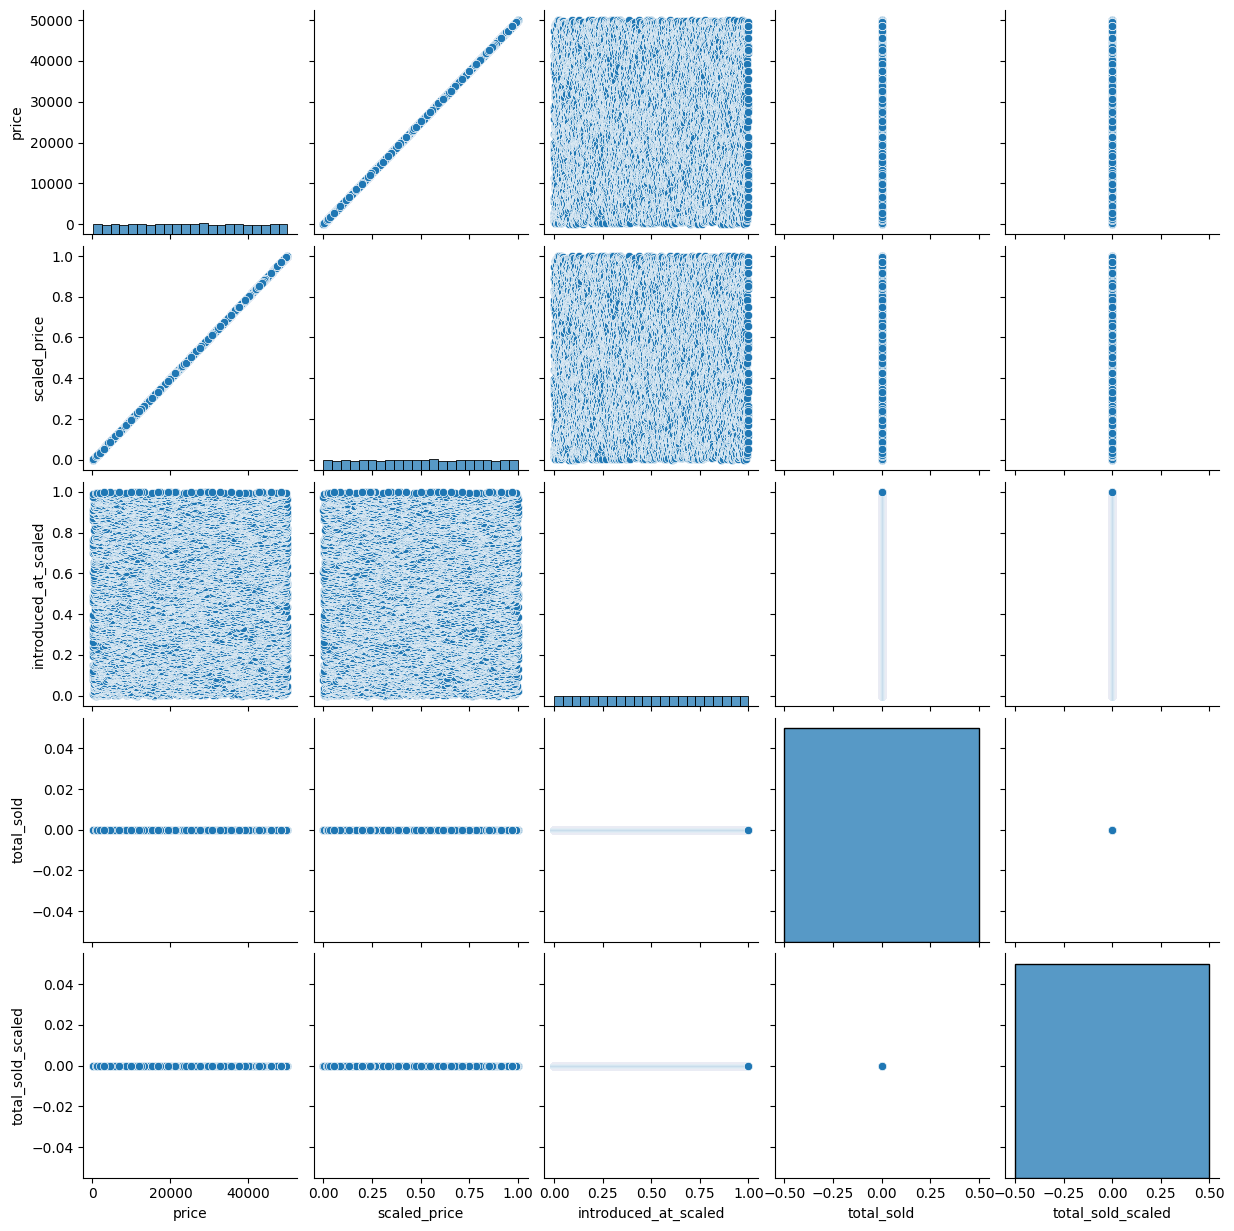

In [16]:
# products_df
sns.pairplot(products_df)
plt.show()